In [ ]:
import numpy as np
import torch
import torch.nn as nn
import os
import matplotlib.pyplot as plt
from torchsummary import summary
from torchvision import transforms, io
from torch.utils.data import Dataset, DataLoader
from PIL import Image
from pathlib import Path
from tqdm import tqdm

In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


In [ ]:
'''
In the cityscapes dataset only 19 labels are included in evaluation
therefore i remapped the 34 original classes to 19, considering the remaining 15 as void
as suggested by the dataset documentation
'''

'''
Dictionary to encode the labels remapping
'''
label_to_trainid = {
    7:0, 8:1, 11:2, 12:3, 13:4, 17:5, 19:6, 20:7, 21:8, 22:9,
    23:10, 24:11, 25:12, 26:13, 27:14, 28:15, 31:16, 32:17, 33:18
}

'''
Function that converts the dataset labels(34) to the training/testing labels(19)
The original labels from 0-33 are remapped into 0-18 following the scheme at this link:
https://github.com/mcordts/cityscapesScripts/blob/878f1d05b1676c669d977a91831ea800482e36c4/cityscapesscripts/helpers/labels.py#L62
'''
def convert_labelIds_to_trainIds(label_img):
    label_copy = torch.full_like(label_img, 255, dtype=torch.long)
    for k, v in label_to_trainid.items():
        label_copy[label_img == k] = v
    return label_copy

# Dataset definition

In [ ]:
'''
Custom dataset to retrieve the dataset image, coloured masks and labelIds masks
coloured masks will be used only to obtain a visual feedback about the segmentation
while labelIds masks will be used to train and test the network
'''
class CityscapeDataset(Dataset):
    def __init__(self, root_path="./data", test=False, image_transform=None, mask_transform=None):
        self.root_path = Path(root_path)
        self.mask_pattern = "**/*_gtFine_color.png"
        self.labelIds_pattern = "**/*_labelIds.png"
        self.image_pattern = "**/*.png"

        if test:
            self.images = sorted(self.root_path.joinpath("Cityscape Dataset/leftImg8bit/test").glob(self.image_pattern))
            self.masks = sorted(self.root_path.joinpath("Fine Annotations/gtFine/test").glob(self.mask_pattern))
            self.labelIds = sorted(self.root_path.joinpath("Fine Annotations/gtFine/test").glob(self.labelIds_pattern))
        else:
            self.images = sorted(self.root_path.joinpath("Cityscape Dataset/leftImg8bit/train/").glob(self.image_pattern))
            self.masks = sorted(self.root_path.joinpath("Fine Annotations/gtFine/train/").glob(self.mask_pattern))
            self.labelIds = sorted(self.root_path.joinpath("Fine Annotations/gtFine/train").glob(self.labelIds_pattern))

        self.image_transform = image_transform
        self.mask_transform = mask_transform

    def __getitem__(self, index):
        img = Image.open(self.images[index]).convert('RGB') # Ensure image is in RGB
        mask = Image.open(self.masks[index]).convert('RGB') # Load coloured mask as RGB
        labelId = Image.open(self.labelIds[index]).convert('L') # Load labelId as grayscale


        if self.image_transform:
            img = self.image_transform(img)
        if self.mask_transform:
            mask = self.mask_transform(mask)
            labelId = self.mask_transform(labelId)

        # dataset ids conversion to train ids
        labelId = convert_labelIds_to_trainIds(labelId)

        return img, mask, labelId

    def __len__(self):
        return len(self.images)

# Net definition

## Encoder

In [ ]:
class conv_block(nn.Module):
    def __init__(self, in_ch, n_filters=64, dropout_prob=0.3, max_pooling=True):
        super().__init__()

        self.conv_1 = nn.Conv2d(in_ch, n_filters, kernel_size=3, padding='same')
        self.conv_2 = nn.Conv2d(n_filters, n_filters, kernel_size=3, padding='same')
        self.activation = nn.ReLU()
        self.max_pooling = max_pooling
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2) if self.max_pooling else None
        self.dropout_prob = dropout_prob
        self.dropout = nn.Dropout(p=dropout_prob)
        self.batch_norm = nn.BatchNorm2d(n_filters)

    def forward(self, x):
        out = self.conv_1(x)
        out = self.activation(out)
        out = self.conv_2(out)
        out = self.activation(out)
        out = self.batch_norm(out)
        if self.dropout_prob > 0:
            out = self.dropout(out)

        skip_connection = out.clone()
        if self.max_pooling:
            next_layer = self.pool(out)
        else:
            next_layer = out

        return next_layer, skip_connection

## Decoder

In [ ]:
class upsampling_block(nn.Module):
    def __init__(self, in_ch, skip_ch, n_filters=64):
        super().__init__()

        self.upsample = nn.ConvTranspose2d(in_ch, in_ch//2, kernel_size=2, stride=(2, 2), padding=0)
        self.conv_1 = nn.Conv2d(in_ch//2 + skip_ch, n_filters, kernel_size=3, padding='same')
        self.conv_2 = nn.Conv2d(n_filters, n_filters, kernel_size=3, padding='same')
        self.activation = nn.ReLU()


    def forward(self, x, skip):
        conv = self.upsample(x)
        conv = torch.cat([conv, skip], dim=1)
        conv = self.conv_1(conv)
        conv = self.activation(conv)
        conv = self.conv_2(conv)
        conv = self.activation(conv)

        return conv

## Final Model

In [ ]:
class UNet(nn.Module):
    def __init__(self, in_ch=3, n_filters=64, n_classes=19):
        super().__init__()
        self.conv_layer_1 = conv_block(in_ch, n_filters, dropout_prob=0, max_pooling=True)
        self.conv_layer_2 = conv_block(n_filters, n_filters*2, dropout_prob=0, max_pooling=True)
        self.conv_layer_3 = conv_block(n_filters*2, n_filters*4, dropout_prob=0, max_pooling=True)
        self.conv_layer_4 = conv_block(n_filters*4, n_filters*8, dropout_prob=0.3, max_pooling=True)
        self.conv_layer_5 = conv_block(n_filters*8, n_filters*16, dropout_prob=0.3, max_pooling=False)

        self.upsample_layer_1 = upsampling_block(n_filters*16, n_filters*8, n_filters*8)
        self.upsample_layer_2 = upsampling_block(n_filters*8, n_filters*4, n_filters*4)
        self.upsample_layer_3 = upsampling_block(n_filters*4, n_filters*2, n_filters*2)
        self.upsample_layer_4 = upsampling_block(n_filters*2, n_filters, n_filters)

        self.last_conv = nn.Sequential(
            nn.Conv2d(n_filters, n_filters, kernel_size=3, padding='same'),
            nn.ReLU(),
            nn.Conv2d(n_filters, n_classes, kernel_size=1, padding='same')
        )

    def forward(self, x):
        conv_1_next, conv_1_skip = self.conv_layer_1(x)
        conv_2_next, conv_2_skip = self.conv_layer_2(conv_1_next)
        conv_3_next, conv_3_skip = self.conv_layer_3(conv_2_next)
        conv_4_next, conv_4_skip = self.conv_layer_4(conv_3_next)
        conv_5_next, conv_5_skip = self.conv_layer_5(conv_4_next)

        out = self.upsample_layer_1(conv_5_next, conv_4_skip)
        out = self.upsample_layer_2(out, conv_3_skip)
        out = self.upsample_layer_3(out, conv_2_skip)
        out = self.upsample_layer_4(out, conv_1_skip)
        out = self.last_conv(out)

        return out

In [ ]:
# Initializing the model
unet = UNet().to(device)

# Printing the model architecture and number of parameters
summary(unet, (3, 128, 256))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 128, 256]           1,792
              ReLU-2         [-1, 64, 128, 256]               0
            Conv2d-3         [-1, 64, 128, 256]          36,928
              ReLU-4         [-1, 64, 128, 256]               0
       BatchNorm2d-5         [-1, 64, 128, 256]             128
         MaxPool2d-6          [-1, 64, 64, 128]               0
        conv_block-7  [[-1, 64, 64, 128], [-1, 64, 128, 256]]               0
            Conv2d-8         [-1, 128, 64, 128]          73,856
              ReLU-9         [-1, 128, 64, 128]               0
           Conv2d-10         [-1, 128, 64, 128]         147,584
             ReLU-11         [-1, 128, 64, 128]               0
      BatchNorm2d-12         [-1, 128, 64, 128]             256
        MaxPool2d-13          [-1, 128, 32, 64]               0
       conv_block-14  [[-

In [ ]:
# Transform definition to preprocess data before passing them through the model
image_transforms = transforms.Compose([
            transforms.Resize((128, 256), interpolation=transforms.InterpolationMode.NEAREST),
            transforms.ToTensor(),
            transforms.Lambda(lambda x: x[0:3])
])

mask_transforms = transforms.Compose([
            transforms.Resize((128, 256), interpolation=transforms.InterpolationMode.NEAREST),
            # we cannot use ToTensor() to transform the mask to tensor because we want to keep the
            # mask values integer
            transforms.Lambda(lambda x: torch.tensor(np.array(x)).long())
])

# Net parameters

In [ ]:
# Hyperparameters definition
EPOCHS = 20
BATCH_SIZE = 32
LR = 0.001

In [ ]:
'''
Loss function definition,
the mask values put to 255 (void regions) are ingored so they do not contribute to the wights update,
doing so the net will not learn to infer 255 mask values in new images
'''
criterion = nn.CrossEntropyLoss(ignore_index=255)

In [ ]:
# Optimizer definition
optimizer = torch.optim.Adam(unet.parameters(), lr=LR)

# Train dataset implementation

In [ ]:
# Definition of the dataset used to train the model
dataset_train = CityscapeDataset(root_path="/kaggle/input/cityscape-dataset", test=False, image_transform=image_transforms, mask_transform=mask_transforms)

In [ ]:
# Definition of the dataloader to iteratively load the images/masks from the train dataset
dataloader_train = DataLoader(dataset=dataset_train, batch_size=BATCH_SIZE, shuffle=True, num_workers=2)

## Train dataset example

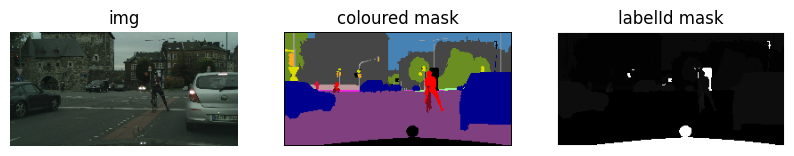

In [ ]:

img, coloured_mask, labelId_mask, = next(iter(dataloader_train))
# Since img is a torch tensor (C, H, W) we have to permute its dimensions -> (H, W, C) before printing it
img1_np = img[0].permute(1, 2, 0).numpy()
img2_np = coloured_mask[0].numpy()
img3_np = labelId_mask[0].numpy()

plt.figure(figsize=(10, 4))

plt.subplot(1, 3, 1)
plt.imshow(img1_np)
plt.title("img")
plt.axis('off')

plt.subplot(1, 3, 2)
plt.imshow(img2_np)
plt.title("coloured mask")
plt.axis('off')

plt.subplot(1, 3, 3)
plt.imshow(img3_np, cmap='gray')
plt.title("labelId mask")
plt.axis("off")

plt.show()

# Training

In [ ]:
losses = []
unet.train()
for epoch in range(EPOCHS):
    epoch_losses = []
    for i, batch in enumerate(dataloader_train):
        images = batch[0].to(device)
        # We use the labelIds_mask to train the network, not the coloured_mask
        labelIds_mask = batch[2].to(device)

        optimizer.zero_grad()

        outputs = unet(images)

        # Compute loss
        loss = criterion(outputs, labelIds_mask)
        epoch_losses.append(loss.item() * images.size(0))

        # Backward pass
        loss.backward()

        # Update parameters
        optimizer.step()
        print(f'EPOCH#{epoch},\t Batch#{i},\t Loss:{loss.item()}')
    losses.append(np.mean(epoch_losses) / len(dataloader_train.dataset))

EPOCH#0,	 Batch#0,	 Loss:0.8258069157600403
EPOCH#0,	 Batch#1,	 Loss:3.770491123199463
EPOCH#0,	 Batch#2,	 Loss:2.245152473449707
EPOCH#0,	 Batch#3,	 Loss:1.4892789125442505
EPOCH#0,	 Batch#4,	 Loss:1.2955403327941895
EPOCH#0,	 Batch#5,	 Loss:1.3756879568099976
EPOCH#0,	 Batch#6,	 Loss:1.2597397565841675
EPOCH#0,	 Batch#7,	 Loss:1.2401018142700195
EPOCH#0,	 Batch#8,	 Loss:1.127814769744873
EPOCH#0,	 Batch#9,	 Loss:1.053799033164978
EPOCH#0,	 Batch#10,	 Loss:1.3406842947006226
EPOCH#0,	 Batch#11,	 Loss:1.0062693357467651
EPOCH#0,	 Batch#12,	 Loss:1.052107810974121
EPOCH#0,	 Batch#13,	 Loss:1.01120924949646
EPOCH#0,	 Batch#14,	 Loss:0.9749411940574646
EPOCH#0,	 Batch#15,	 Loss:0.9167989492416382
EPOCH#0,	 Batch#16,	 Loss:1.0185987949371338
EPOCH#0,	 Batch#17,	 Loss:0.8984177708625793
EPOCH#0,	 Batch#18,	 Loss:0.9307000041007996
EPOCH#0,	 Batch#19,	 Loss:0.8483374714851379
EPOCH#0,	 Batch#20,	 Loss:0.9077947735786438
EPOCH#0,	 Batch#21,	 Loss:0.9030624032020569
EPOCH#0,	 Batch#22,	 Loss:0

[0.009428135240973091, 0.006777422234888612, 0.006153564354026287, 0.005629761568347624, 0.00510374568025088, 0.004765656095560601, 0.004534200226979451, 0.00437347364875912, 0.0041897426532020825, 0.004078735785184001, 0.003785126518619365, 0.0037100119576540767, 0.0035162569680079934, 0.0033619513433671335, 0.0032996095547435235, 0.003175005289643742, 0.003064893662170137, 0.0029513901475861737, 0.002850418926373271, 0.002753137844714238]


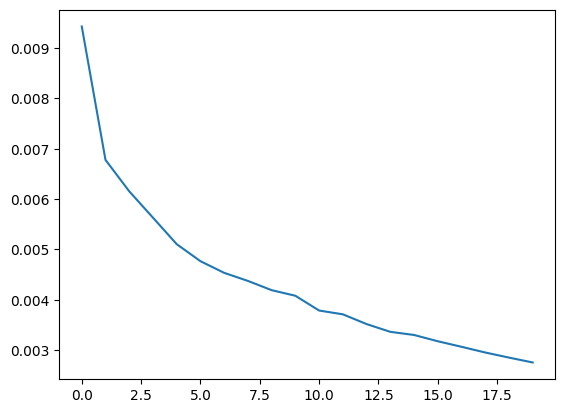

In [ ]:
# Plot to see the evolution of the loss during the training
print(losses)
plt.plot(np.arange(len(losses)), losses)

In [ ]:
# Save the model
PATH = '/kaggle/working/U-Net-Cityscapes_3.pth'
torch.save(unet.state_dict(), PATH)

In [ ]:
# Load the model
PATH = '/kaggle/input/u-net-cityscapes-1/pytorch/default/1/U-Net-Cityscapes_2.pth'
unet.load_state_dict(torch.load(PATH, device))

<All keys matched successfully>

# Test dataset implementation

In [ ]:
# Definition of the dataset used to test the model
dataset_test = CityscapeDataset(root_path="/kaggle/input/cityscape-dataset", test=True, image_transform=image_transforms, mask_transform=mask_transforms)

In [ ]:
# Definition of the dataloader to iteratively load the images/masks from the test dataset
dataloader_test = DataLoader(dataset=dataset_train, batch_size=BATCH_SIZE, shuffle=False, num_workers=2)

# Testing

In [ ]:
# Function to compute the Intersection over Union rate
'''
Takes as input:
    preds: tensor [B, C, H, W] -> output raw logits of the model
    targets: tensor [B, H, W] -> ground truth (trainId)
    num_classes: number of classes (e.g. 19 for Cityscapes)
    ignore_index: value to be ingored in the grounf truth targets (es. 255)
'''
def compute_iou_torch(preds, targets, num_classes=19, ignore_index=255):
    # Conversion from logits to classes
    preds = torch.argmax(preds, dim=1)  # [B, H, W]

    # Crafting the mask to ignore the 255 values
    mask = targets != ignore_index
    preds = preds[mask]
    targets = targets[mask]

    iou_per_class = torch.zeros(num_classes, device=preds.device)
    for c in range(num_classes):
        pred_c = preds == c
        target_c = targets == c

        intersection = (pred_c & target_c).sum().float()
        union = (pred_c | target_c).sum().float()

        # If the union == 0 then we ignore this result in the final iou computation
        if union == 0:
            iou_per_class[c] = torch.nan
        else:
            iou_per_class[c] = intersection / union

    mean_iou = torch.nanmean(iou_per_class)

    return iou_per_class, mean_iou


In [ ]:
unet.eval()
total_iou = torch.zeros(19).to(device)
num_batches = 0

with torch.no_grad():
    for images, _, labels in tqdm(dataloader_test, desc="IoU", total=len(dataloader_test), unit="batch"):
        images = images.to(device)
        labels = labels.to(device)

        outputs = unet(images)
        iou_per_class, mean_iou = compute_iou_torch(outputs, labels)

        total_iou += torch.nan_to_num(iou_per_class)
        num_batches += 1

mean_iou_final = (total_iou / num_batches).mean()
print(f"Final mean IoU: {mean_iou_final.item():.4f}")
for i, iou in enumerate(iou_per_class):
    print(f"Class {i:02d} → IoU = {iou.item():.4f}")

IoU: 100%|██████████| 93/93 [03:11<00:00,  2.06s/batch]

Final mean IoU: 0.3724
Class 00 → IoU = 0.9443
Class 01 → IoU = 0.7501
Class 02 → IoU = 0.7569
Class 03 → IoU = 0.2026
Class 04 → IoU = 0.0461
Class 05 → IoU = 0.2681
Class 06 → IoU = 0.0175
Class 07 → IoU = 0.2772
Class 08 → IoU = 0.8130
Class 09 → IoU = 0.4592
Class 10 → IoU = 0.8770
Class 11 → IoU = 0.1123
Class 12 → IoU = 0.0000
Class 13 → IoU = 0.7209
Class 14 → IoU = 0.0086
Class 15 → IoU = 0.0060
Class 16 → IoU = 0.0000
Class 17 → IoU = 0.0000
Class 18 → IoU = 0.1738


# Visual Benchmarks

In [ ]:
# Cytiscapes color map for the 19 classes (trainId)
trainId2label = {
     0:  ("road", (128, 64,128)),
     1:  ("sidewalk", (244, 35,232)),
     2:  ("building", (70, 70, 70)),
     3:  ("wall", (102,102,156)),
     4:  ("fence", (190,153,153)),
     5:  ("pole", (153,153,153)),
     6:  ("traffic light", (250,170, 30)),
     7:  ("traffic sign", (220,220,  0)),
     8:  ("vegetation", (107,142, 35)),
     9:  ("terrain", (152,251,152)),
    10: ("sky", (70,130,180)),
    11: ("person", (220, 20, 60)),
    12: ("rider", (255,  0,  0)),
    13: ("car", (0,  0,142)),
    14: ("truck", (0,  0, 70)),
    15: ("bus", (0, 60,100)),
    16: ("train", (0, 80,100)),
    17: ("motorcycle", (0,  0,230)),
    18: ("bicycle", (119, 11, 32))
}

In [ ]:
'''
Function to convert the grayscale labelIds to an rgb image in order to be compared
to the coloured ground truth mask
Input:
        mask: torch.Tensor [H, W] or np.ndarray [H, W]
    Output:
        color_mask: np.ndarray [H, W, 3] (uint8)
'''
def colorize_mask(mask):
    if torch.is_tensor(mask):
        mask = mask.cpu().numpy()

    color_mask = np.zeros((mask.shape[0], mask.shape[1], 3), dtype=np.uint8)

    for train_id, (label_name, color) in trainId2label.items():
        color_mask[mask == train_id] = color

    return color_mask

In [ ]:
# Function to print in the same plot three different images
def display(display_list):
    plt.figure(figsize=(15, 15))

    title = ['Input Image', 'True Mask', 'Predicted Mask']

    for i in range(len(display_list)):
        plt.subplot(1, len(display_list), i+1)
        plt.title(title[i])
        if(i in (1,2)):
            plt.imshow(display_list[i])
        else:
            plt.imshow(display_list[i].permute(1, 2, 0))
        plt.axis('off')
    return plt

In [ ]:
# Function that converts the logits to the actual classes
def create_mask(pred_mask):
    pred_mask = torch.argmax(pred_mask, dim=1).detach()
    return pred_mask

In [ ]:
# Function that displays the first image of each of the num batches
def show_predictions(dataloader, device, num=1):
    unet.eval()

    with torch.no_grad():
        for i, batch in enumerate(dataloader):
            # RGB image
            IMG = batch[0][0, :, : ,:].to(device).unsqueeze(0)
            # Coloured mask
            MASK = batch[1][0, :, :, :].to(device).unsqueeze(0)
            # LabelIds prediction
            pred_mask = unet.to(device)(IMG)
            # Plotting the three images next to each other
            display([IMG[0].cpu(), MASK[0].cpu(), colorize_mask(create_mask(pred_mask).cpu()[0])]).show()

            if i >= num:
                break

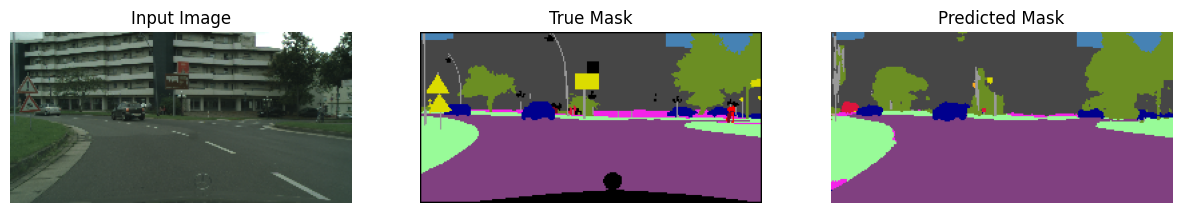

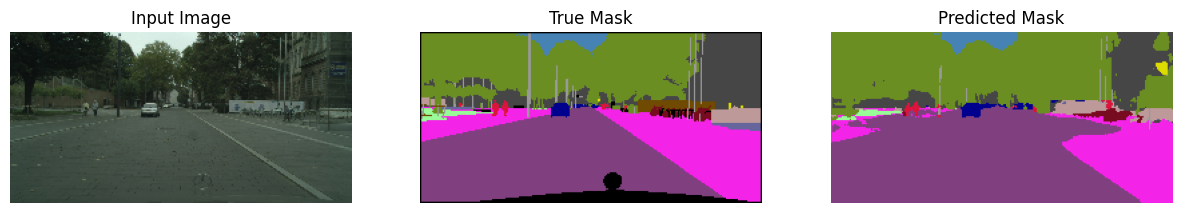

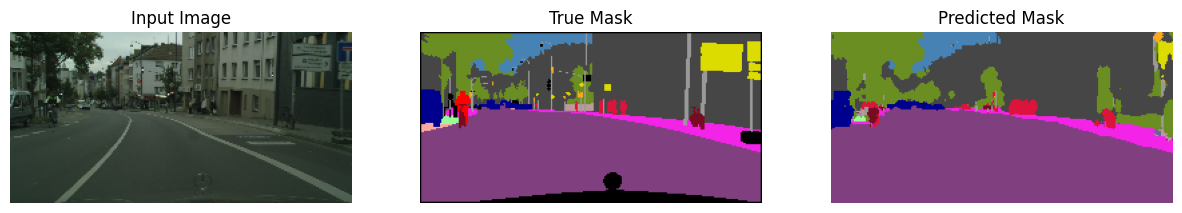

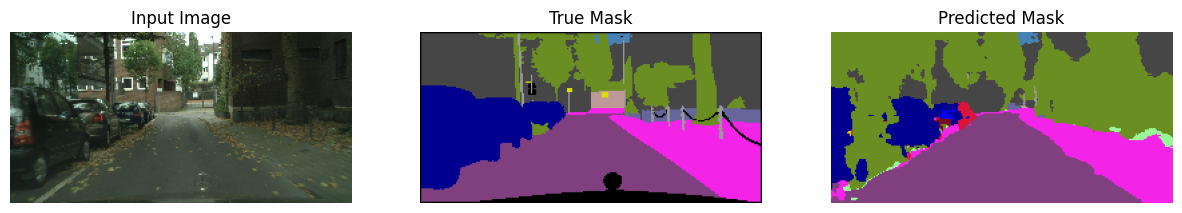

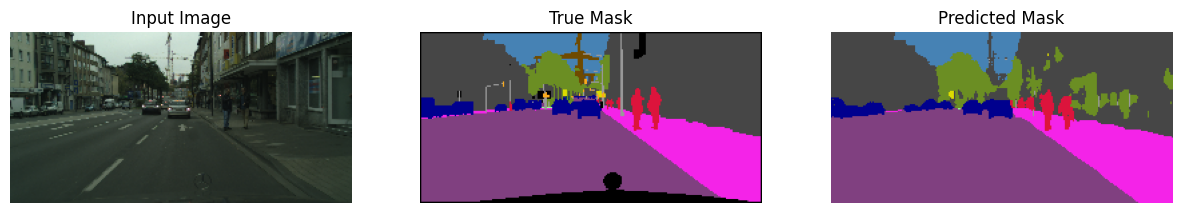

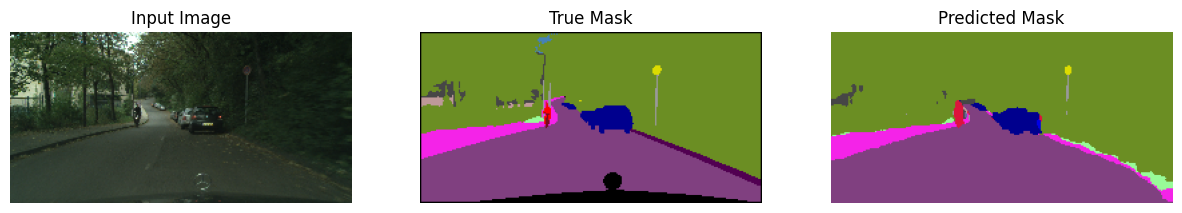

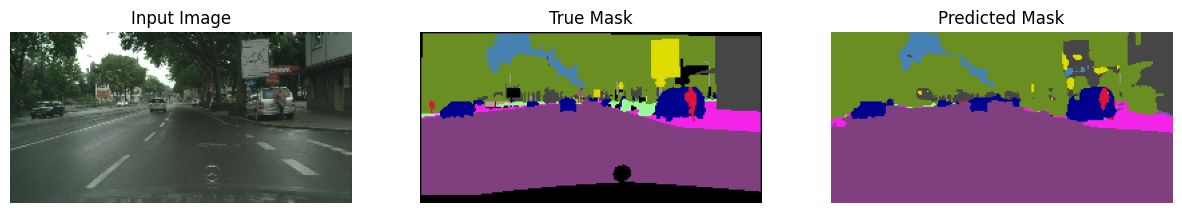

In [ ]:
# Showing n random images from the test dataset with the ground truth mask and the predicted mask
show_predictions(dataloader_test, device, 6)

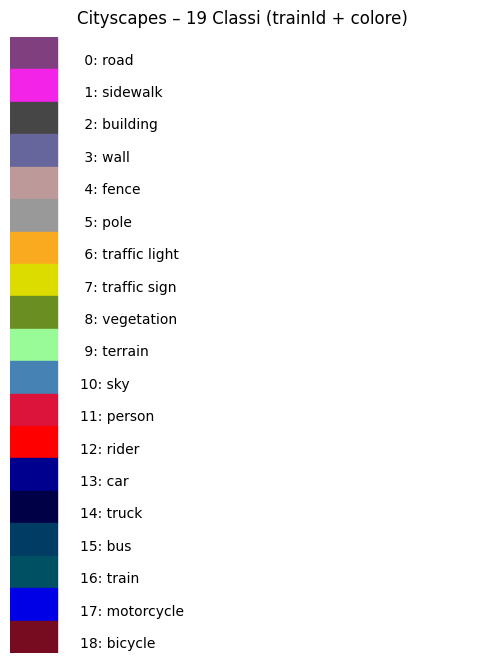

In [ ]:
# Crea figura
fig, ax = plt.subplots(figsize=(6, 8))
ax.set_xlim(0, 10)
ax.set_ylim(0, len(trainId2label))
ax.axis("off")

# Disegna rettangolini colorati con testo accanto
for i, (train_id, (name, color)) in enumerate(trainId2label.items()):
    y = len(trainId2label) - i - 1
    rgb = np.array(color) / 255.0  # normalizza per matplotlib
    ax.add_patch(plt.Rectangle((0, y), 1, 1, color=rgb))
    ax.text(1.5, y + 0.3, f"{train_id:2d}: {name}", fontsize=10, va="center")

plt.title("Cityscapes – 19 Classi (trainId + colore)", fontsize=12, pad=10)
plt.show()
